In [48]:
#Linear forecasting model by estimating the autoregressive (AR(p)) regression coefficients of timeseries

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [50]:
eps = 0.15 #pacf acceptance threshold is considered to be non-zero

In [51]:
#Calculate sample autocovariance function (ACVF)
def Gamma_hat(h, x):
    x = np.array(x)
    h = int(np.abs(h))
    x_bar = np.mean(x)
    gamma_hat = 0
    for t in range(len(x)-h):
        gamma_hat += (x[t+h] - x_bar)*(x[t] - x_bar)
    return gamma_hat/len(x)

In [52]:
#Calculate vector sample autocovariance function (ACVF)
def Gamma_hat_vector(h, x):
    h = np.abs(h)
    gamma_vector = np.zeros(h)
    for i in range(h):
        gamma_vector[i] = Gamma_hat(i+1, x)
    return np.array(gamma_vector)

In [53]:
#Calculate matrix covariance
def Cov_matrix(n, x):
    n = np.abs(n)
    cov_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov_matrix[i, j] = Gamma_hat(i-j, x)
    return np.array(cov_matrix)


In [54]:
#Calculate the value of partial autocorrelation function (PACF)
def PACF(h, x, Cov_hat):
    h = np.abs(h)
    if h == 0:
        return 1
    else:
        PHI = np.linalg.inv(Cov_hat[0:h, 0:h]) @ np.hstack([Cov_hat[0, 1:h], Gamma_hat(h, x)]).T
        return PHI[h-1]

In [ ]:
#Calculate and plot vector partial autocorrelation function (PACF)
def comp_and_draw_PACF(X, eps, Cov_hat):
    pacf = []
    n = len(X)
    for h in range(0, n+1):
        pacf.append(PACF(h, X, Cov_hat))

    plt.ylim(-1,1)
    plt.plot(pacf, 'g-')
    plt.plot(np.zeros(n), 'b')
    plt.plot([eps for i in range(n)], 'y')
    plt.plot([-eps for i in range(n)], 'y')
    plt.title('PACF')
    plt.grid(True)
    plt.show()
    return np.array(pacf)

In [55]:
data = pd.read_csv("data.csv")
data

,time,price
0,1/12/2022,2377.00
1,1/11/2022,2227.00
2,1/10/2022,2155.50
3,1/9/2022,2363.00
4,1/8/2022,2497.00
...,...,...
174,1/4/2008,2959.27
175,1/3/2008,3005.29
176,1/2/2008,2776.93
177,1/1/2008,2445.52


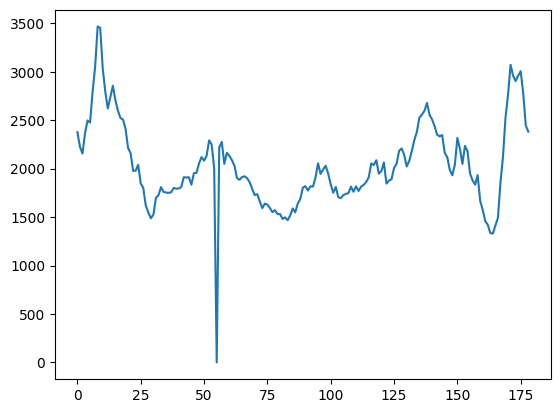

In [70]:
data_X = np.array(data["price"])
plt.plot(data_X)
plt.show()

In [67]:
#Replace all values equal to 0 with the mean value of the data up to that point
#Alternatively, use the data before the point = 0 to predict one step for the missing data point.
for i in range(len(data_X)):
  if data_X[i] <= 0:
    data_X[i] = np.mean(data_X[:i])
#Calculate the average filter of the data.
data_X_mean = np.mean(data_X)
X = data_X - data_X_mean

array([ 331.13962417,  181.13962417,  109.63962417,  317.13962417,
        451.13962417,  430.13962417,  746.13962417, 1005.13962417,
       1421.13962417, 1408.13962417,  988.13962417,  750.13962417,
        574.88962417,  689.38962417,  808.88962417,  661.13962417,
        551.88962417,  476.88962417,  460.63962417,  366.13962417,
        169.63962417,  112.63962417,  -69.86037583,  -66.11037583,
         -6.61037583, -198.36037583, -244.61037583, -426.86037583,
       -498.61037583, -557.86037583, -520.61037583, -346.61037583,
       -320.11037583, -236.61037583, -286.11037583, -292.36037583,
       -295.86037583, -289.86037583, -245.61037583, -252.36037583,
       -250.86037583, -236.36037583, -133.86037583, -137.11037583,
       -134.86037583, -211.11037583,  -92.86037583,  -89.61037583,
          7.13962417,   73.88962417,   36.63962417,   85.88962417,
        245.63962417,  203.38962417,  -41.11037583,  130.5668969 ,
        172.63962417,  229.63962417,    2.63962417,  117.13962

In [59]:
Cov_matrix_hat = Cov_matrix(len(X), X)
Cov_matrix_hat

array([[168495.80197029, 160155.91380347, 146902.27193646, ...,
          1962.57289663,   1079.19100367,    621.26533819],
       [160155.91380347, 168495.80197029, 160155.91380347, ...,
          3354.49303871,   1962.57289663,   1079.19100367],
       [146902.27193646, 160155.91380347, 168495.80197029, ...,
          4662.93292457,   3354.49303871,   1962.57289663],
       ...,
       [  1962.57289663,   3354.49303871,   4662.93292457, ...,
        168495.80197029, 160155.91380347, 146902.27193646],
       [  1079.19100367,   1962.57289663,   3354.49303871, ...,
        160155.91380347, 168495.80197029, 160155.91380347],
       [   621.26533819,   1079.19100367,   1962.57289663, ...,
        146902.27193646, 160155.91380347, 168495.80197029]])

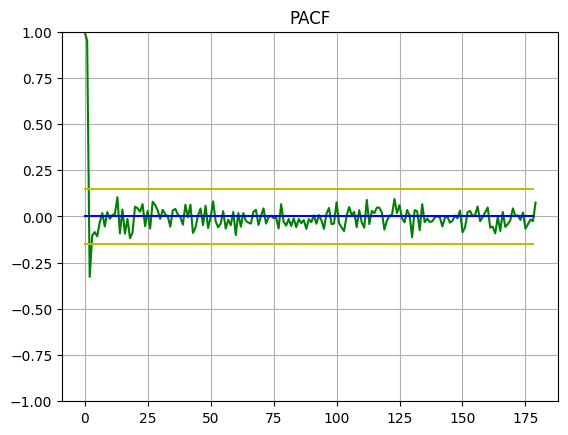

In [60]:
pacf = comp_and_draw_PACF(X, eps, Cov_matrix_hat)

In [61]:
max_i = 0
for i in range(len(pacf)):
    if np.abs(pacf[i]) >= eps:
        max_i = i

max_i

2

In [62]:
#Model parameter estimation function
def Predict_Phi(m, x, Cov):
    Cov = np.fliplr(Cov)
    Gamma_right = Gamma_hat_vector(len(x) + m, x)
    Phi = np.linalg.inv(Cov) @ np.flip(Gamma_right[m:m+max_i]).T
    return np.array(Phi)

In [63]:
predict = []
for i in range(12):
  predict.append(Predict_Phi(7*12+i+1, X, Cov_matrix_hat[0:max_i, 0:max_i]))

In [64]:
#Price prediction
X_predict = []
for i in range(12):
  X_predict.append(predict[i] @ np.flip(X[-max_i:]).T)

X_predict += data_X_mean


In [65]:
List_Predict = {}

In [66]:
for i in range(12):
  List_Predict["Month " + str( i+1) + " year 2030"] = str(X_predict[i]) + " $"

List_Predict

{'Month 1 year 2030': '2007.2025372984801 $',
 'Month 2 year 2030': '1998.9715508414108 $',
 'Month 3 year 2030': '1993.611791098238 $',
 'Month 4 year 2030': '1984.0506787644094 $',
 'Month 5 year 2030': '1978.4979739958744 $',
 'Month 6 year 2030': '1971.450883503687 $',
 'Month 7 year 2030': '1968.0814670699965 $',
 'Month 8 year 2030': '1965.144826000183 $',
 'Month 9 year 2030': '1958.8665738595896 $',
 'Month 10 year 2030': '1956.2499015782748 $',
 'Month 11 year 2030': '1958.9864951126476 $',
 'Month 12 year 2030': '1958.5543261638788 $'}